In [ ]:
import numpy as np

In [566]:
import odl

In [567]:
%matplotlib inline

In [568]:
import matplotlib.pyplot as plt

## Load CT volume

In [569]:
from path import Path
import pydicom

ct_dir_path = Path('/mnt/data/olivierv/Cyl/AC_CT_0003/')

In [570]:
type(ct_dir_path)

path.Path

In [571]:
import itertools

def array_from_dicom_list(imas):
    """
    Takes a list of dicom images and orders the in a NumPy array.
    """
    shuffled_volume = np.array([ima.pixel_array for ima in imas])
    pos = [int(ima.InstanceNumber) - 1 for ima in imas]
    volume = np.zeros_like(shuffled_volume)
    volume[pos] = shuffled_volume
    return volume

def space_from_dicom_list(imas):
    ima = imas[0]
    shape = ima.pixel_array.shape
    spans = [pixel_size*nb_pixels for pixel_size, nb_pixels in zip(ima.PixelSpacing, shape)]
    locs = np.array([float(ima.SliceLocation) for ima in imas])
    min_pt, max_pt = (locs.min(), -spans[0]/2, -spans[1]/2), (locs.max(), spans[0]/2, spans[1]/2)
    vol_shape = (len(imas), shape[0], shape[1])
    return odl.discr.uniform_discr(min_pt=min_pt, max_pt=max_pt, shape=vol_shape, axis_labels=('z','y','x'))
    # todo: check that the order is indeed z,y,x in the end

def dicom_generator(path):
    gen = (pydicom.read_file(f) for f in path.listdir())
    return gen

def volume_from_dicom(path):
    """
    `path` must be of type Path
    """
    imas = list(dicom_generator(path))
    data = array_from_dicom_list(imas)
    return space_from_dicom_list(imas).element(data[::-1])

def get_property(path, key):
    gen = dicom_generator(path)
    return getattr(list(itertools.islice(gen,1))[0], key)

In [572]:
ct_volume = volume_from_dicom(ct_dir_path)

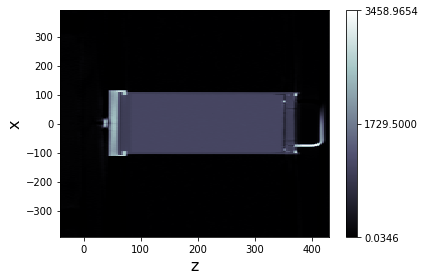

<Figure size 432x288 with 0 Axes>

In [573]:
ct_volume.show(coords=(None,0,None));

## Convert to attenuation map

In [574]:
kvp_dict = {"80": 
{
"a": 3.64e-5,
"b": 6.261e-2,
"breakpoint": 50,
},
"100":
{
"a": 4.43e-5,
"b": 5.44e-2,
"breakpoint": 52,
},
"110":
{
"a": 4.92e-5,
"b": 4.88e-2,
"breakpoint": 43,
},
"120":
{
"a": 5.1e-5,
"b": 4.71e-2,
"breakpoint": 47,
},
"130":
{
"a": 5.51e-5,
"b": 4.24e-2,
"breakpoint": 37,
},
"140":
{
"a": 5.64e-5,
"b": 4.08e-2,
"breakpoint": 30,
},
}
def affine_attenuation_conversion(volume, breakpoint, a, b):
    attenuation = np.zeros_like(volume, dtype=np.float)
    #volume_ = volume - 24
    volume_ = volume
    small = volume_ < breakpoint
    attenuation[small] = (volume_[small])*(9.6e-5)
    attenuation[~small] = a*(volume_[~small]) + b
    attenuation[attenuation < 0] = 0
    return attenuation

def attenuation_correction(volume, kvp='120'):
    return affine_attenuation_conversion(volume, **kvp_dict[str(kvp)])

In [575]:
kvp = get_property(ct_dir_path, 'KVP')

In [576]:
kvp = get_property(ct_dir_path, 'KVP')

In [577]:
get_property(ct_dir_path, 'RescaleSlope')

"1"

In [578]:
get_property(ct_dir_path, 'RescaleIntercept')

"-1024"

In [579]:
attenuation_array = attenuation_correction(ct_volume.asarray())

In [580]:
attenuation_array.shape

(158, 512, 512)

In [581]:
attenuation_volume = ct_volume.space.element(attenuation_array)

In [582]:
attenuation_volume.shape

(158, 512, 512)

In [583]:
attenuation_volume[70,256,256]

0.102231

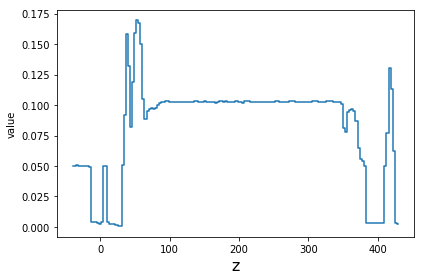

<Figure size 432x288 with 0 Axes>

In [584]:
attenuation_volume.show(coords=(None,0,0));

## Load PET data

In [585]:
from pathlib import Path

In [586]:
base_path = Path("/mnt/data/olivierv/")

In [587]:
data_path = base_path / "Decompressed"

In [588]:
import numpy as np

In [589]:
sino_arrays = [ np.load(data_path / 'P0{}.npy'.format(i)) for i in range(3)]

In [590]:
header_paths = [data_path / 'P0{}.s.hdr'.format(i) for i in range(3)]

## Fetch bed position in mm

In [591]:
def get_bed_position_mm(path):
    with open(path) as f:
        for line in f:
            if line.startswith('start horizontal bed position'):
                value = float(line.split(':=')[1])
                return value

In [592]:
get_bed_position_mm(header_paths[0])

-576.51

## Get CT slice for a given offset

In [593]:
#def get_attenuation_slice(ct_volume, offset, thickness=226.72):
def get_attenuation_slice(ct_volume, offset, thickness=216.):
    """
    ct_volume: odl volume, z coordinate first
    """
    # compute indices from pixel size and origin
    pixel_thickness = ct_volume.space.cell_sides[0]
    ct_space = ct_volume.space
    length_from_left = (offset - ct_space.min_pt[0])
    slice_offset = int(length_from_left/pixel_thickness)
    span = int(thickness/pixel_thickness)
    ct_slice = ct_volume[slice_offset:slice_offset+span]
    # pad with zero
    padded_ct_slice = np.zeros((span, ct_volume.shape[1], ct_volume.shape[2]))
    padded_ct_slice[:len(ct_slice)] = ct_slice
    # compute appropriate space
    min_pt, max_pt = ct_volume.space.min_pt, ct_volume.space.max_pt
    slice_space = odl.discr.uniform_discr(min_pt=[0, min_pt[1], min_pt[2]], 
                                          max_pt=[thickness ,max_pt[1], max_pt[2]], 
                                          shape=padded_ct_slice.shape, 
                                          axis_labels=ct_volume.space.axis_labels)
    return slice_space.element(padded_ct_slice)

In [594]:
distance_constant = 252 + (-576)

In [595]:
print(distance_constant)

-324


In [596]:
def get_ct_offset(bed_position, distance=-324):
    """
    bed_position is the interfile key is "start horizontal bed position (mm)"
    """
    return -bed_position + distance

In [597]:
import odl

# Reconstruction

In [598]:
bed_position = 1

## Prepare data for bed position

In [599]:
sino = sino_arrays[bed_position]

In [600]:
#data  = (sino[...,::2] + sino[...,1::2])/2
data = sino

## Prepare attenuation for bed position

In [601]:
bed_position_mm = get_bed_position_mm(header_paths[bed_position])

In [602]:
attenuation_slice = get_attenuation_slice(attenuation_volume, get_ct_offset(bed_position_mm))

In [603]:
attenuation_slice.space

uniform_discr([   0., -390., -390.], [ 216.,  390.,  390.], (72, 512, 512))

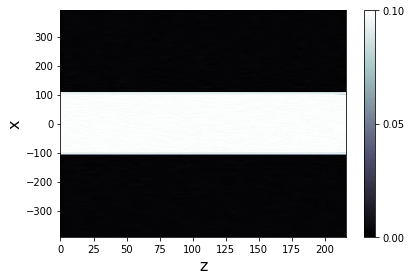

<Figure size 432x288 with 0 Axes>

In [604]:
attenuation_slice.show(coords=(None,0,None));

In [631]:
attenuation_slice.shape

(72, 512, 512)

### PET Projector

In [605]:
from odlpet import Compression, Scanner

In [606]:
%run mct.py

<Figure size 432x288 with 0 Axes>

In [607]:
c = Compression(mCT())

In [608]:
c.num_of_views = 168
c.num_non_arccor_bins = 400
#c.num_non_arccor_bins = 200
c.data_arc_corrected = True
c.span_num = 11
# the following is new:
c.max_num_segments = 45

In [609]:
c.scanner.num_rings

55

In [647]:
#proj = c.get_projector(stir_domain=c.get_stir_domain(sizes=(109,200,200)), restrict_to_cylindrical_FOV=False)
proj = c.get_projector(stir_domain=c.get_stir_domain(sizes=(18,400,400)),restrict_to_cylindrical_FOV=True)

In [648]:
proj.domain

uniform_discr([   0., -800., -800.], [  37.44,  800.  ,  800.  ], (18, 400, 400), dtype='float32')

## Resampling

In [649]:
attenuation_slice.space

uniform_discr([   0., -390., -390.], [ 216.,  390.,  390.], (72, 512, 512))

Note: the following is suboptimal: we change a space with coordinates ±390 to a space with coordinates -400,+408.

In [650]:
dummy_space = odl.discr.lp_discr.uniform_discr(min_pt=proj.domain.min_pt, max_pt=proj.domain.max_pt, shape=attenuation_slice.shape)

In [651]:
sampled_attenuation_slice = proj.domain.element(dummy_space.element(attenuation_slice).interpolation)

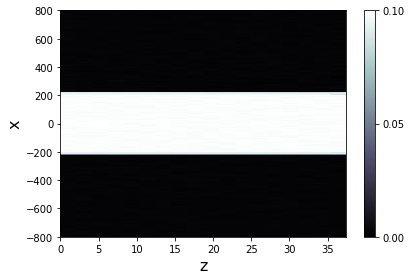

<Figure size 432x288 with 0 Axes>

In [652]:
sampled_attenuation_slice.show(coords=(None,0,None));

## Attenuation

In [653]:
def get_attenuation_multiplicator(operator, attenuation_volume):
    pixel_size = operator.domain.cell_sides[1]
    atn_proj = operator(attenuation_volume)
    return np.exp(-atn_proj*pixel_size/10)

In [654]:
proj.domain.cell_sides

array([ 2.08000003,  4.        ,  4.        ])

In [655]:
proj

ForwardProjectorByBinWrapper: uniform_discr([   0., -800., -800.], [  37.44,  800.  ,  800.  ], (18, 400, 400), dtype='float32') -> uniform_discr([   0.,    0., -421.], [ 621.    ,    3.1416,  421.    ], (621, 168, 400), dtype='float32')

In [656]:
%%time
attenuation_multiplicator = get_attenuation_multiplicator(proj, sampled_attenuation_slice)

RuntimeError: std::bad_alloc

## MLEM

In [619]:
corrected_data = data/attenuation_multiplicator

ValueError: operands could not be broadcast together with shapes (621,168,400) (621,168,200) 

In [539]:
attenuation_multiplicator.shape

(621, 168, 200)

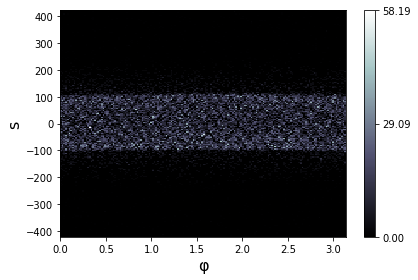

<Figure size 432x288 with 0 Axes>

In [549]:
proj.range.element(corrected_data).show(indices=(19,None,None));

In [560]:
reco = proj.domain.one()

In [551]:
mlem = odl.solvers.iterative.statistical.mlem

In [562]:
tot_iters = 0

In [561]:
iters = 10

In [563]:
%%time
tot_iters += iters
mlem(proj, reco, corrected_data, niter=iters)

CPU times: user 9min 34s, sys: 2.56 s, total: 9min 36s
Wall time: 9min 12s


In [437]:
reco_nc = proj.domain.one()

In [438]:
%%time
tot_iters += iters
mlem(proj, reco_nc, data, niter=iters)

CPU times: user 2min 18s, sys: 568 ms, total: 2min 18s
Wall time: 2min 13s


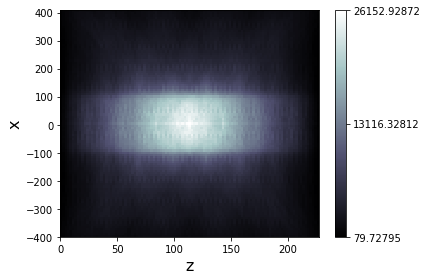

<Figure size 432x288 with 0 Axes>

In [249]:
ad_reco = proj.adjoint( corrected_data)
ad_reco.show(coords=(None,0,None));

<Figure size 1080x720 with 0 Axes>

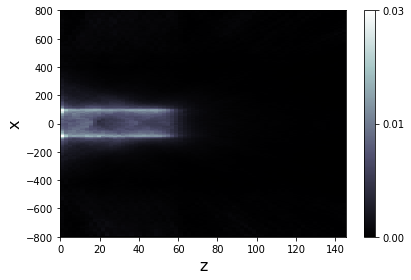

<Figure size 432x288 with 0 Axes>

In [454]:
plt.figure(figsize=(15,10))
reco_nc.show(coords=(None,0,None));

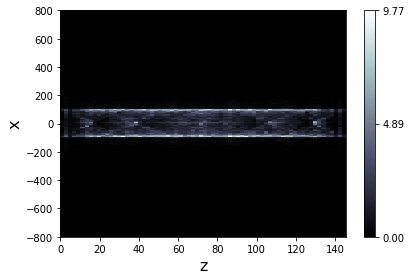

<Figure size 432x288 with 0 Axes>

In [555]:
reco.show(coords=(None,0,None));

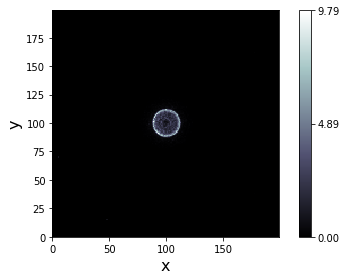

<Figure size 432x288 with 0 Axes>

In [557]:
reco[20].show(aspect='equal');

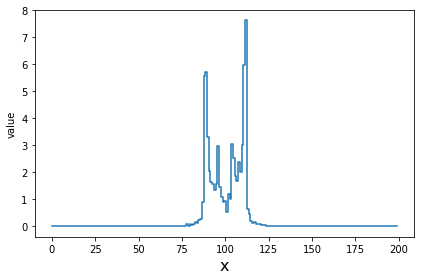

<Figure size 432x288 with 0 Axes>

In [558]:
reco[20,100,:].show();

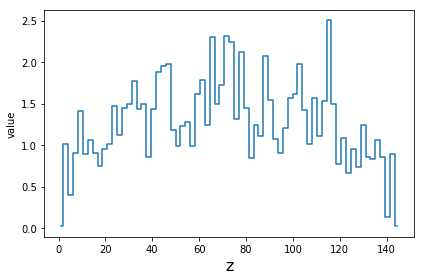

<Figure size 432x288 with 0 Axes>

In [559]:
reco.show(coords=(None,0,50));

### Save Reconstruction

In [286]:
save_dir = base_path / "cylrecosatn"

In [653]:
save_path = save_dir / "reco-{}-{}-{}.npy".format(bed_position, reco.shape[1], tot_iters)

In [654]:
print(save_path)

/mnt/data/olivierv/cylrecosatn/reco-1-101-6.npy


In [655]:
np.save(save_path, reco)

## Load saved reconstruction

In [66]:
!ls {save_dir}

reco-0-101-2.npy  reco-1-101-2.npy  reco-2-101-2.npy


In [103]:
reco0 = proj.domain.element(np.load(save_dir / "reco-0-101-2.npy"))

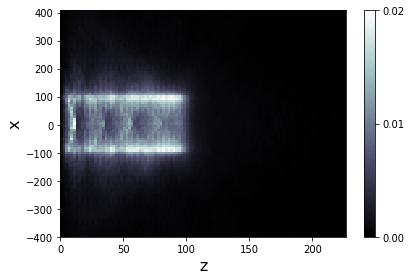

<Figure size 432x288 with 0 Axes>

In [104]:
fig = reco0.show(coords=(None,0,None));
#fig.savefig('reco0xz_.png')

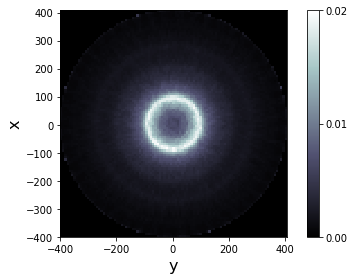

<Figure size 432x288 with 0 Axes>

In [105]:
fig = reco0.show(coords=(40,None,None), aspect='equal')
#fig.savefig('reco0xy_.png')

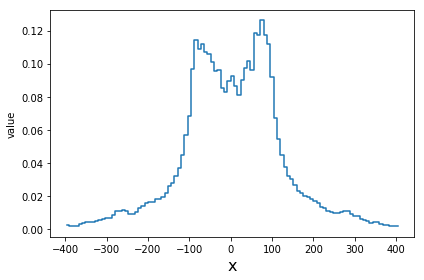

<Figure size 432x288 with 0 Axes>

In [95]:
fig = reco0.show(coords=(40,0,None))

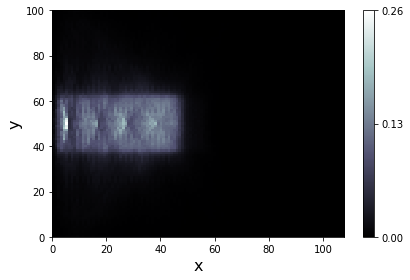

<Figure size 432x288 with 0 Axes>

In [73]:
reco0[:,50,:].show();